## RestNet  50 Tensorflow v2



In [1]:
import numpy as np
import tensorflow as tf

from keras.layers import Input
from keras.layers import Conv2D
from keras.layers import ZeroPadding2D
from keras.layers import BatchNormalization
from keras.layers import Activation
from keras.layers import MaxPool2D
from keras.layers import GlobalAveragePooling2D
from keras.layers import Flatten
from keras.layers import Dense
from keras.layers import Add

import matplotlib.pyplot as plt
from keras.models import Model
from keras.utils.data_utils import get_file

from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.applications.resnet50 import decode_predictions
from keras.utils.vis_utils import plot_model

print(tf.__version__)

2.11.0


In [2]:
input_size = (224, 224, 3)
weights_path = "https://github.com/sumitbinnani/Dog-Breed-Classifier/blob/master/saved_models/weights.best.Resnet50.hdf5"

In [3]:
def identity_block(input_tensor, kernel_size, filters):
    layer = Conv2D(filters[0], kernel_size=(1, 1))(input_tensor)
    layer = BatchNormalization(axis=3)(layer)
    layer = Activation('relu')(layer)
        
    layer = Conv2D(filters[1], kernel_size, padding='same')(layer)
    layer = BatchNormalization(axis=3)(layer)
    layer = Activation('relu')(layer)
    
    layer = Conv2D(filters[2], (1, 1))(layer)
    layer = BatchNormalization(axis=3)(layer)

    layer = Add()([layer, input_tensor])
    layer = Activation('relu')(layer)
    
    return layer


def convolutional_block(input_tensor, kernel_size, stride, filters):
    layer = Conv2D(filters[0], kernel_size=(1, 1), strides=(stride, stride))(input_tensor)
    layer = BatchNormalization(axis=3)(layer)
    layer = Activation('relu')(layer)
    
    layer = Conv2D(filters[1], kernel_size=(kernel_size, kernel_size), padding='same')(layer)
    layer = BatchNormalization(axis=3)(layer)
    layer = Activation('relu')(layer)
    
    layer = Conv2D(filters[2], kernel_size=(1, 1))(layer)
    layer = BatchNormalization(axis=3)(layer)
    
    x_shortcut = Conv2D(filters[2], kernel_size=(1, 1), strides=(stride, stride))(input_tensor)
    x_shortcut = BatchNormalization(axis=3)(x_shortcut)
    
    layer = Add()([layer, x_shortcut])
    layer = Activation('relu')(layer)
    
    return layer

In [4]:
def build_restnet50_model(input_shape=input_size, classes=1000):
    input_layer = Input(input_shape)

    layer_1 = ZeroPadding2D(padding=(3, 3))(input_layer)
    layer_1 = Conv2D(filters=64, kernel_size=(7, 7), strides=(2, 2))(layer_1)
    layer_1 = BatchNormalization(axis=3)(layer_1)
    layer_1 = Activation('relu')(layer_1)
    layer_1 = ZeroPadding2D(padding=(1, 1))(layer_1)
    layer_1 = MaxPool2D(pool_size=(3, 3), strides=(2, 2))(layer_1)
    
    layer_2 = convolutional_block(layer_1, kernel_size=3, stride=1, filters=[64, 64, 256])
    layer_2 = identity_block(layer_2, kernel_size=3, filters=[64, 64, 256])
    layer_2 = identity_block(layer_2, kernel_size=3, filters=[64, 64, 256])
    
    layer_3 = convolutional_block(layer_2, kernel_size=3, stride=2, filters=[128, 128, 512])
    layer_3 = identity_block(layer_3, kernel_size=3, filters=[128, 128, 512])
    layer_3 = identity_block(layer_3, kernel_size=3, filters=[128, 128, 512])
    layer_3 = identity_block(layer_3, kernel_size=3, filters=[128, 128, 512])
    
    layer_4 = convolutional_block(layer_3, kernel_size=3, stride=2, filters=[256, 256, 1024])
    layer_4 = identity_block(layer_4, kernel_size=3, filters=[256, 256, 1024])
    layer_4 = identity_block(layer_4, kernel_size=3, filters=[256, 256, 1024])
    layer_4 = identity_block(layer_4, kernel_size=3, filters=[256, 256, 1024])
    layer_4 = identity_block(layer_4, kernel_size=3, filters=[256, 256, 1024])
    layer_4 = identity_block(layer_4, kernel_size=3, filters=[256, 256, 1024])

    layer_5 = convolutional_block(layer_4, kernel_size=3, stride=2, filters=[512, 512, 2048])
    layer_5 = identity_block(layer_5, kernel_size=3, filters=[512, 512, 2048])
    layer_5 = identity_block(layer_5, kernel_size=3, filters=[512, 512, 2048])

    layer_5 = GlobalAveragePooling2D(name='avg_pool')(layer_5)
    output_layer = Dense(units=classes, activation='softmax')(layer_5)
    
    model = Model(inputs=input_layer, outputs=output_layer, name='ResNet50')
    
    return model

### Transfer Learning (TL)

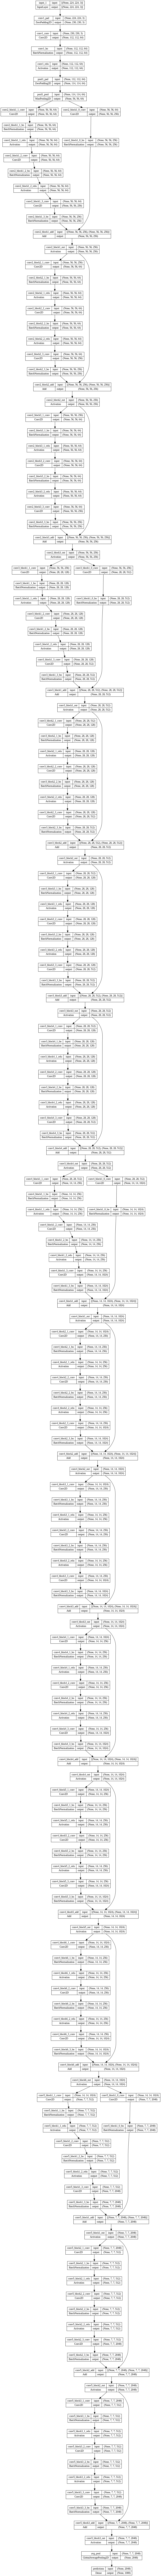

In [5]:
model_restnet50 = ResNet50()
plot_model(model_restnet50, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

## Model Inference

1/1 [==============================] - 2s 2s/step


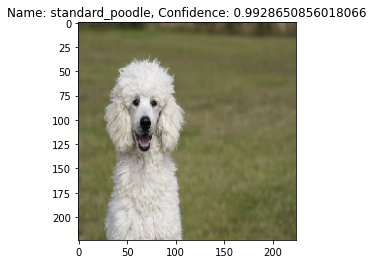

In [6]:
def predict_image(model, image_path: str):
    img_predict = image.load_img(image_path, target_size=(input_size[0], input_size[1]))

    plt.imshow(img_predict)

    img_predict = image.img_to_array(img_predict)
    img_predict = np.expand_dims(img_predict, axis=0)

    output_predict = model.predict(preprocess_input(img_predict))
    output_class_predict = decode_predictions(output_predict)[0][0]
    output_probs_predict = output_class_predict[2]
    output_class_predict = output_class_predict[1]
    plt.title(f"Name: {output_class_predict}, Confidence: {output_probs_predict}")

predict_image(model_restnet50, '/content/poodle.jpg')